## GeekBrains / Машинное обучение в бизнесе

## Домашнее задание А.Николаев / Урок 3. Кейс 1. Работа с признаками и селекция

### Задача №1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по 1 месяцу.

In [99]:
%matplotlib inline
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import numpy as np
import pandas as pd
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.stattools import jarque_bera as jb
from statsmodels.iolib.table import SimpleTable

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [4]:
df.tail()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2018-08-02,20:00:00,44057.0,2018,8,2,3,214,31,3,20,0,0,0
2018-08-02,21:00:00,43256.0,2018,8,2,3,214,31,3,21,0,0,0
2018-08-02,22:00:00,41552.0,2018,8,2,3,214,31,3,22,0,0,0
2018-08-02,23:00:00,38500.0,2018,8,2,3,214,31,3,23,0,0,0
2018-08-03,00:00:00,35486.0,2018,8,3,3,215,31,4,0,0,0,0


In [5]:
df.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


In [6]:
df_month = df.resample('M').mean()
df_month = df_month['PJME_MW']

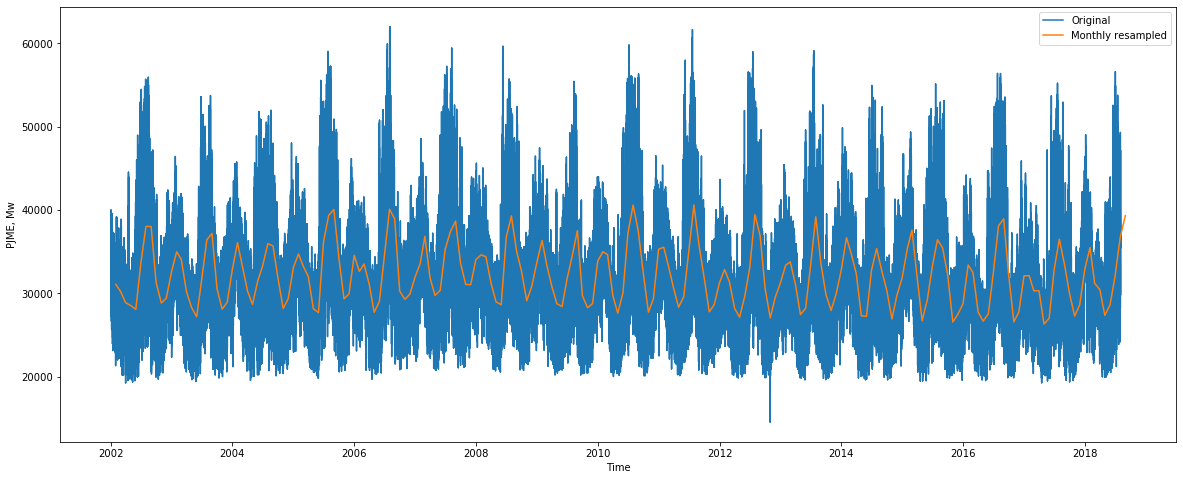

In [7]:
plt.figure(figsize=(20, 8))
plt.plot(df['PJME_MW'], label='Original')
plt.plot(df_month, label='Monthly resampled')
plt.ylabel('PJME, Mw')
plt.xlabel('Time')
plt.legend()
plt.show()

### Задача №2. Подберите параметры модели SARIMAX для этого ряда.

##### Как видим из приведенного выше графика ряд имеет один ярко выраженный выброс и не имеет тренда.

##### Проверим рад на стационарность

In [8]:
df_stats = df_month.describe()
df_stats

count      200.000000
mean     32108.628796
std       3534.668371
min      26314.458333
25%      29193.559812
50%      31879.175067
75%      34574.729839
max      40603.403226
Name: PJME_MW, dtype: float64

In [9]:
# вычислим коэффициент вариации
v = df_stats['std'] / df_stats['mean']
print(f'Коэффициент вариации = {v}')

Коэффициент вариации = 0.11008468761685114


##### Судя по коэффициенту вариации, наш ряд не сильно изменчив. Но надо проверить еще нормальность распределения. Проверим ряд тестом Харки-Бера на предмет близости к номальному распределению.

In [10]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = jb(df_month)
a = np.vstack([jb_test])
_jb = SimpleTable(a, row)
print(_jb)

       JB              p-value               skew             kurtosis    
--------------------------------------------------------------------------
9.73583133415776 0.007689375815619433 0.4306187608725617 2.346876970826132
--------------------------------------------------------------------------


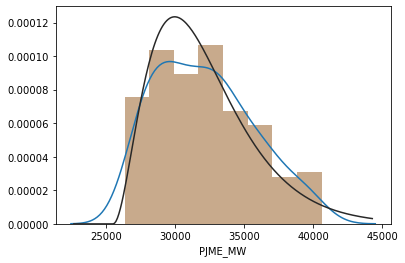

In [11]:
plt_sns = sns.distplot(df_month)
plt_sns = sns.distplot(df_month, kde=False, fit=stats.gamma)

##### Статистика Харки-Бера информирует нас о том, что нулевая гипотеза о нормальности распределения отвергается с малой вероятностью (probably > 0.05) и следовательно наш ряд имеет близкое к нормальному распределение.

##### Для проверки ряда на стационарность проведем обобщенный тест Дикки-Фуллера на наличие единичных корней.

In [12]:
adf_test = sm.tsa.adfuller(df_month)
print(f'adf: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print(f'Critical values: {adf_test[4]}')
print('Есть единичные корни, ряд не стационарен') if adf_test[0] > adf_test[4]['5%'] \
                                                  else print('Единичных корней нет, ряд стационарен')

adf: -1.9529633722403592
p-value: 0.307569912099962
Critical values: {'1%': -3.466398230774071, '5%': -2.8773796387256514, '10%': -2.575213838610586}
Есть единичные корни, ряд не стационарен


##### Обобщенный тест Дикки-Фуллера подтвердил предположения о не стационарности ряда

##### Возьмем первые разности нашего ряда, чтобы посмотрть, является ли рад первых разностей стационарным.

In [13]:
df_month_1diff = df_month.diff(periods=1).dropna()

In [14]:
# проведет тест Дикки-Фуллера на стационарность для первых разностей
adf_test = sm.tsa.adfuller(df_month_1diff)
print(f'adf: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print(f'Critical values: {adf_test[4]}')
print('Есть единичные корни, ряд не стационарен') if adf_test[0] > adf_test[4]['5%'] \
                                                  else print('Единичных корней нет, ряд стационарен')

adf: -6.098227372855428
p-value: 9.980345490649288e-08
Critical values: {'1%': -3.466398230774071, '5%': -2.8773796387256514, '10%': -2.575213838610586}
Единичных корней нет, ряд стационарен


##### Т.к. первые разности ряда df_month стационарны, то наш ряд называется интегрированным рядом первого порядка. Построим график ряда первых разностей и убедимся в гипотезе

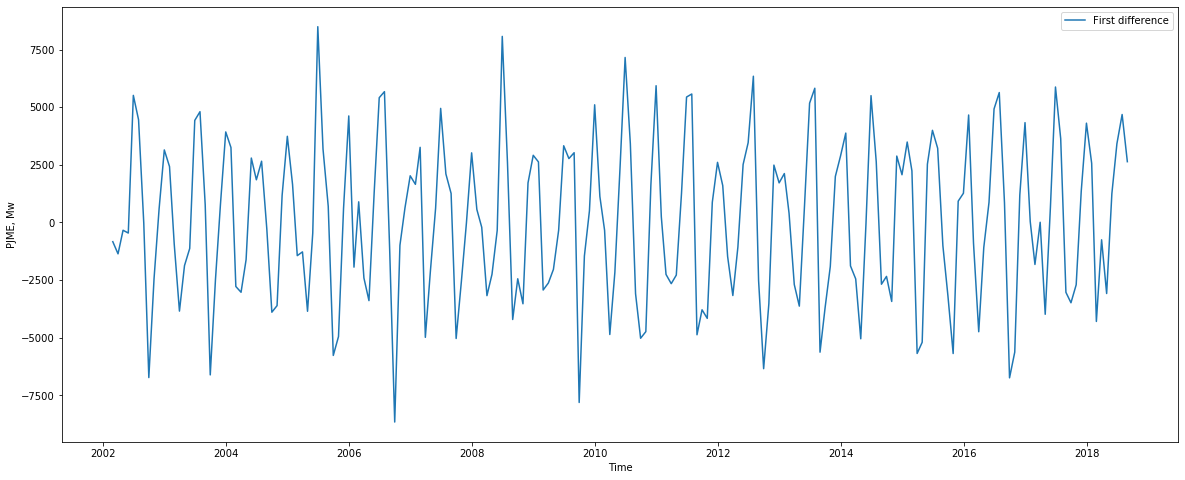

In [15]:
plt.figure(figsize=(20, 8))
plt.plot(df_month_1diff, label='First difference')
plt.ylabel('PJME, Mw')
plt.xlabel('Time')
plt.legend()
plt.show()

##### Зная порядов ряда первых разностей, мы нашли значение параметра d = 1 модели SARIMA

In [16]:
d_SARIMA = 1

In [17]:
df_month.shape

(200,)

##### Построим автокореляцию и частичную автокоррелцию по массиву лагов (значений назад) =  [8, 16, 24, 32, 48]. Т.к. в нашем ряду после ресемплинга в представлении по неделям стало 200 недель, то и максимальное знаечние лага = 48 оправдано. Графики автокорреляции и частичной актокорреляции помогут нам выбрать первичные значения параметров p и q модели SARIMA

[ 1.          0.50911327 -0.29093435 -0.68304235 -0.35693915  0.28774769
  0.64218431  0.32119717 -0.34823995].3f
-0.6830423488748403 0.6421843052920579
-0.7527592135769549 0.5116716318154597


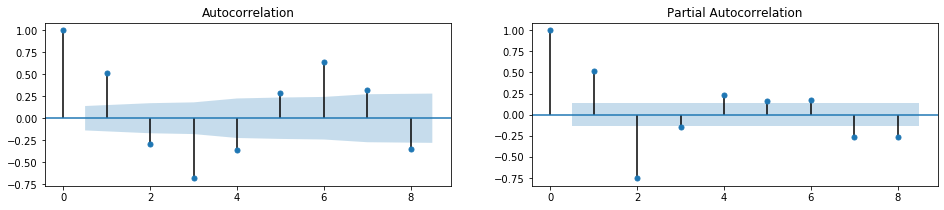

[ 1.          0.50911327 -0.29093435 -0.68304235 -0.35693915  0.28774769
  0.64218431  0.32119717 -0.34823995 -0.69190215 -0.31089821  0.42387979
  0.78848201  0.42186962 -0.2889944  -0.66303189 -0.32391105].3f
-0.6919021534235806 0.7884820131419215
-0.7527592135769549 0.5116716318154597


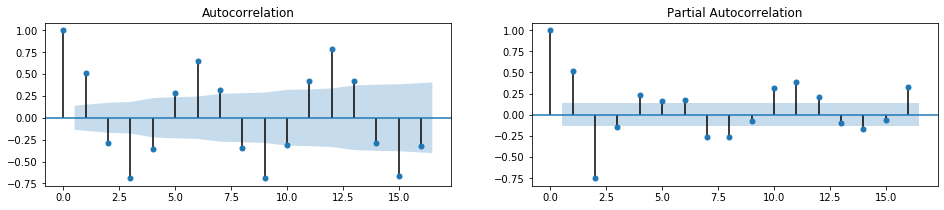

[ 1.          0.50911327 -0.29093435 -0.68304235 -0.35693915  0.28774769
  0.64218431  0.32119717 -0.34823995 -0.69190215 -0.31089821  0.42387979
  0.78848201  0.42186962 -0.2889944  -0.66303189 -0.32391105  0.3085795
  0.6114986   0.31211576 -0.32288096 -0.66625467 -0.3046449   0.38794683
  0.71619175].3f
-0.6919021534235806 0.7884820131419215
-0.7527592135769549 0.5116716318154597


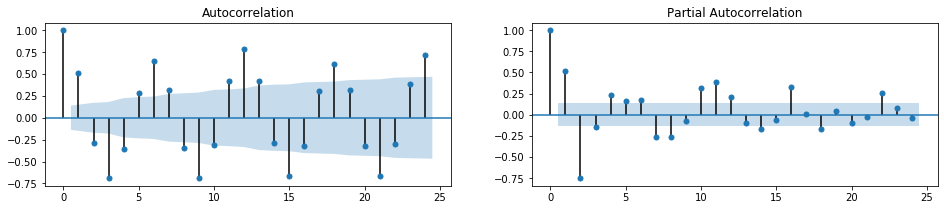

[ 1.          0.50911327 -0.29093435 -0.68304235 -0.35693915  0.28774769
  0.64218431  0.32119717 -0.34823995 -0.69190215 -0.31089821  0.42387979
  0.78848201  0.42186962 -0.2889944  -0.66303189 -0.32391105  0.3085795
  0.6114986   0.31211576 -0.32288096 -0.66625467 -0.3046449   0.38794683
  0.71619175  0.3688731  -0.28491418 -0.63030572 -0.32752862  0.27129294
  0.60486285  0.30329612 -0.30179813].3f
-0.6919021534235806 0.7884820131419215
-0.7527592135769549 0.5116716318154597


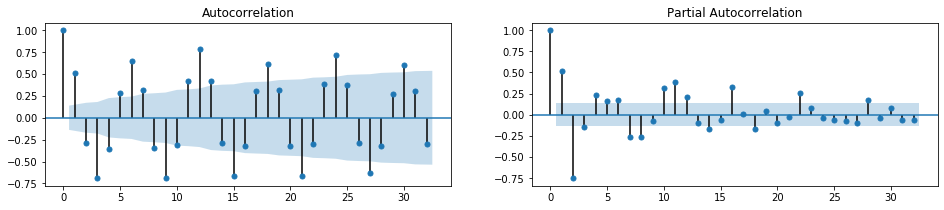

[ 1.          0.50911327 -0.29093435 -0.68304235 -0.35693915  0.28774769
  0.64218431  0.32119717 -0.34823995 -0.69190215 -0.31089821  0.42387979
  0.78848201  0.42186962 -0.2889944  -0.66303189 -0.32391105  0.3085795
  0.6114986   0.31211576 -0.32288096 -0.66625467 -0.3046449   0.38794683
  0.71619175  0.3688731  -0.28491418 -0.63030572 -0.32752862  0.27129294
  0.60486285  0.30329612 -0.30179813 -0.59420044 -0.27986731  0.34205023
  0.67523931  0.35999881 -0.27380835 -0.58863316 -0.31325695  0.24303531
  0.5342039   0.25978484 -0.28331875 -0.5594668  -0.26847112  0.31676705
  0.61571779].3f
-0.6919021534235806 0.7884820131419215
-0.7527592135769549 0.5116716318154597


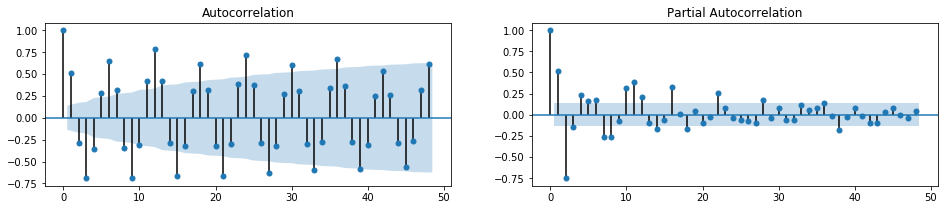

In [18]:
LAGS = [8, 16, 24, 32, 48]
acf = {}
pacf = {}
for lag in LAGS:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))
    # print(f'Count lags - {lag}')
    sm.graphics.tsa.plot_acf(df_month.values, lags=lag, ax=ax1)
    acf[lag] = sm.tsa.stattools.acf(df_month.values, nlags=lag)
    # print(f'{acf[lag]}')
    print(min(acf[lag]), max(acf[lag][1:]))
    sm.graphics.tsa.plot_pacf(df_month.values, lags=lag, ax=ax2)
    pacf[lag] = sm.tsa.stattools.pacf(df_month.values, nlags=lag)
    # print(f'{pacf[lag]}')
    print(min(pacf[lag]), max(pacf[lag][1:]))
    plt.show()

##### Исходя их анализа автокорреляций и частичных корреляций находим значения p и q. Видим, что уже на лаге = 16 недель назад, минимальные и максимальные значения автокорреляции и частичной автокорреляции становятся одинаковыми и рассмотрение лоагов большего порядка не имеет смысла.
##### Автокорреляция ACF даст нам значение q
##### Частичная автокорреляция PACF даст нам значение p

In [33]:
q_SARIMA = 12
p_SARIMA = 2
pdq = [p_SARIMA, d_SARIMA, q_SARIMA]
print(f'ARIMA параметры модели SARIMA = {pdq}')

ARIMA параметры модели SARIMA = [2, 1, 12]


##### Для дальнейшей работы, нам необходимо разобраться с сезонностью и найти сезонные параметры P, D, Q для модели SARIMA.

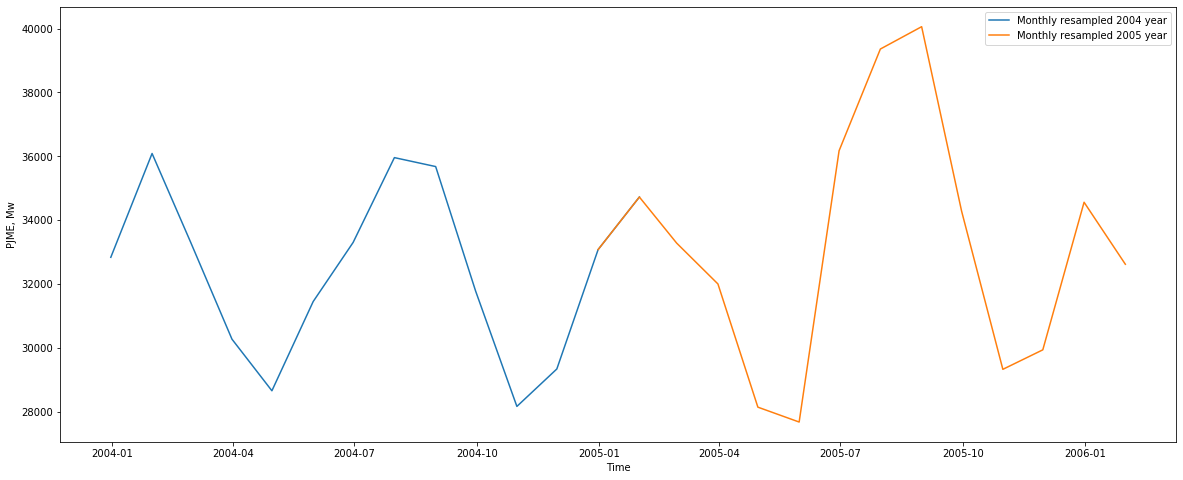

In [20]:
# Построим график ряда выделив в нем 2 года (год к году 2 года подряд), чтобы посмотреть ближе на сезонность.
df_month2004 = df_month.loc['2003-12-01':'2005-01-31']
df_month2005 = df_month.loc['2004-12-01':'2006-01-31']
plt.figure(figsize=(20, 8))
plt.plot(df_month2004, label='Monthly resampled 2004 year')
plt.plot(df_month2005, label='Monthly resampled 2005 year')
plt.ylabel('PJME, Mw')
plt.xlabel('Time')
plt.legend()
plt.show()

##### Как видим из графика, каждый год имеются 2 пика потребления энергии и 2 провала в ее потреблении. Позоже, что период сезонности потребления энергии равен половине года. Учитывая, что в году 12 месяцев, возьмем за основу сезонности 6 месяцев.

In [21]:
# найдем сезонный ряд, продифференцировав исходный на period = 6
df_month_1diff_season = df_month_1diff.diff(periods=6).dropna()

In [22]:
# проведет тест Дикки-Фуллера на стационарность
adf_test = sm.tsa.adfuller(df_month_1diff_season)
print(f'adf: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print(f'Critical values: {adf_test[4]}')
print('Есть единичные корни, ряд не стационарен') if adf_test[0] > adf_test[4]['5%'] \
                                                  else print('Единичных корней нет, ряд стационарен')

adf: -7.517596249320423
p-value: 3.8662158206095957e-11
Critical values: {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}
Единичных корней нет, ряд стационарен


In [23]:
# т.к. ряд сезонной разности стационарен, то порядок интегрированности сезонной разности = 0, т.е. D_SARIMA = 0
Ds_SARIMA = 0

##### Для нахождения параметров P и Q сезонной составляющей, построим автокорреляцию и частичную автокорреляцию сезонной составляющей.
##### Для их оценки надо смотреть на лаги кратные размеру сезонности, т.е., если наша сезонность 6 месяцев, то надо рассматривать кратные лаги 12, 18, 24, ...

Count lags - 12
-0.5991384645281704 0.28968155645491245
-0.5920641490562517 0.196667872437127


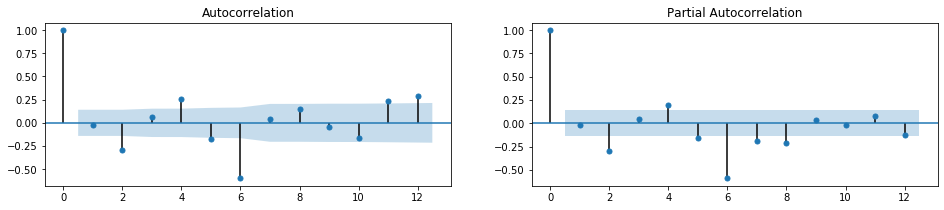

Count lags - 18
-0.5991384645281704 0.28968155645491245
-0.5920641490562517 0.196667872437127


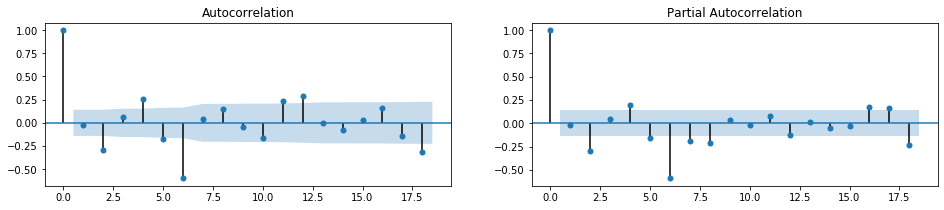

In [24]:
LAGS = [12, 18]
acf = {}
pacf = {}
for lag in LAGS:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))
    print(f'Count lags - {lag}')
    sm.graphics.tsa.plot_acf(df_month_1diff_season.values, lags=lag, ax=ax1)
    acf[lag] = sm.tsa.stattools.acf(df_month_1diff_season.values, nlags=lag)
    # print(f'{acf[lag]}')
    print(min(acf[lag]), max(acf[lag][1:]))
    sm.graphics.tsa.plot_pacf(df_month_1diff_season.values, lags=lag, ax=ax2)
    pacf[lag] = sm.tsa.stattools.pacf(df_month_1diff_season.values, nlags=lag)
    # print(f'{pacf[lag]}')
    print(min(pacf[lag]), max(pacf[lag][1:]))
    plt.show()

In [34]:
Qs_SARIMA = 6
Ps_SARIMA = 6
PDQs = [Ps_SARIMA, Ds_SARIMA, Qs_SARIMA, 6]
print(f'Сезонные параметры модели SARIMA = {PDQs}')

Сезонные параметры модели SARIMA = [6, 0, 6, 6]


### В результате исследований мы получаем модель SARIMA(2, 1, 12)(6, 0, 6)6 

In [35]:
%%time
# Cформируем модель, используя все данные, кроме 7-и последних месяцев (на один месяц больше сезонного периода). 
# 7 послежних месяцев ряда - наш тестовый набор.
model_manual = sm.tsa.statespace.SARIMAX(df_month.values[:-7], order=pdq, seasonal_order=PDQs, 
                                  enforce_stationarity= False, enforce_invertibility=False)
result_manual = model_manual.fit()
print(f'SARIMAX {pdq} x {PDQs} - AIC:{result_manual.aic}')

SARIMAX [2, 1, 12] x [6, 0, 6, 6] - AIC:2538.7000835
Wall time: 31.5 s


In [36]:
print(result_manual.summary().tables[0], result_manual.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  193
Model:             SARIMAX(2, 1, 12)x(6, 0, 6, 6)   Log Likelihood               -1242.350
Date:                            Thu, 21 May 2020   AIC                           2538.700
Time:                                    09:07:18   BIC                           2618.697
Sample:                                         0   HQIC                          2571.207
                                            - 193                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

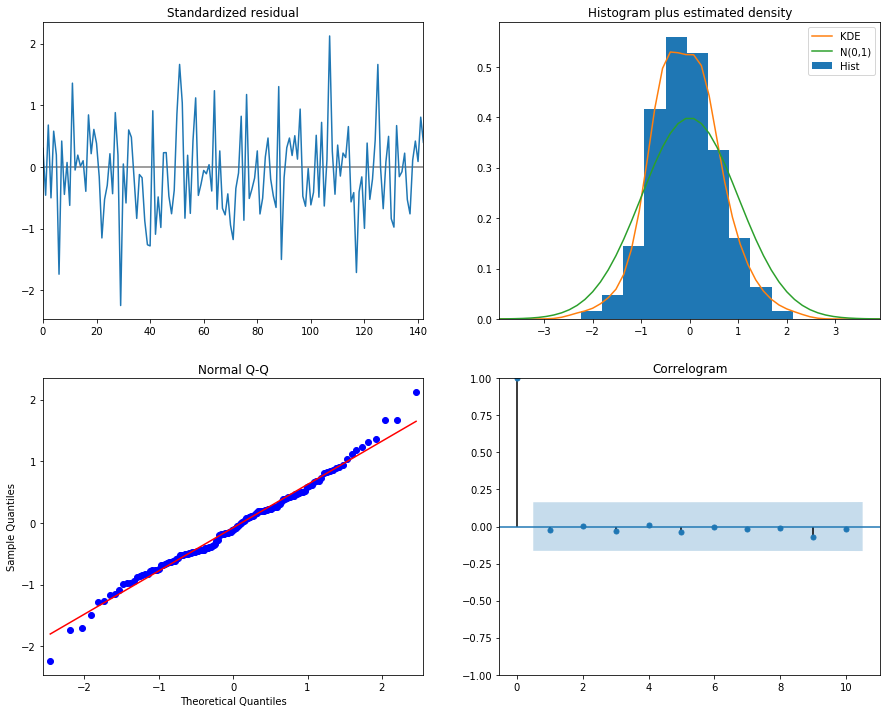

In [37]:
result_manual.plot_diagnostics(figsize=(15, 12))
plt.show()

### Попробуем подобрать параметры модели SARIMA построив сетку и запустив перебор с выбором наилучшего (минимального) AIC

In [29]:
# %%time
# best_aic = None
# best_pdq = None
# best_PDQs = None
# best_model = None
# p = range(0, 3)
# d = [1]
# q = range(0, 12)
# pdq_list = list(itertools.product(p, d, q))
# p = range(0, 6) 
# d = [0]
# q = range(0, 6)
# PDQs_list = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
# for pdq in tqdm(pdq_list):
#     for PDQs in PDQs_list:
#         try:
#             model = sm.tsa.statespace.SARIMAX(df_month.values[:-7], order=pdq, seasonal_order=PDQs, 
#                                               enforce_stationarity= False, enforce_invertibility=False)
#             result = model.fit()
#             # print(f'SARIMAX {pdq} x {PDQs} - AIC:{result.aic}')
#             if (best_aic is None) or (best_aic > result.aic):
#                 best_aic = result.aic
#                 best_pdq = pdq
#                 best_PDQs = PDQs
#                 best_model = model
#         except:
#             continue

100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [1:57:31<00:00, 195.89s/it]


Wall time: 1h 57min 31s


In [31]:
print(f'Best AIC: {best_aic}')
print(f'Best pdq: {best_pdq}')
print(f'Best PDQs: {best_PDQs}')

Best AIC: 2652.270101078623
Best pdq: (2, 1, 11)
Best PDQs: (1, 0, 5, 6)


In [64]:
# result.save('rez_model.h5')
result = sm.load('rez_model.h5')

##### После сеточного подбора параметров, получились следующие данные:

Best AIC: 2652.270101078623

Best pdq: (2, 1, 11)

Best PDQs: (1, 0, 5, 6)

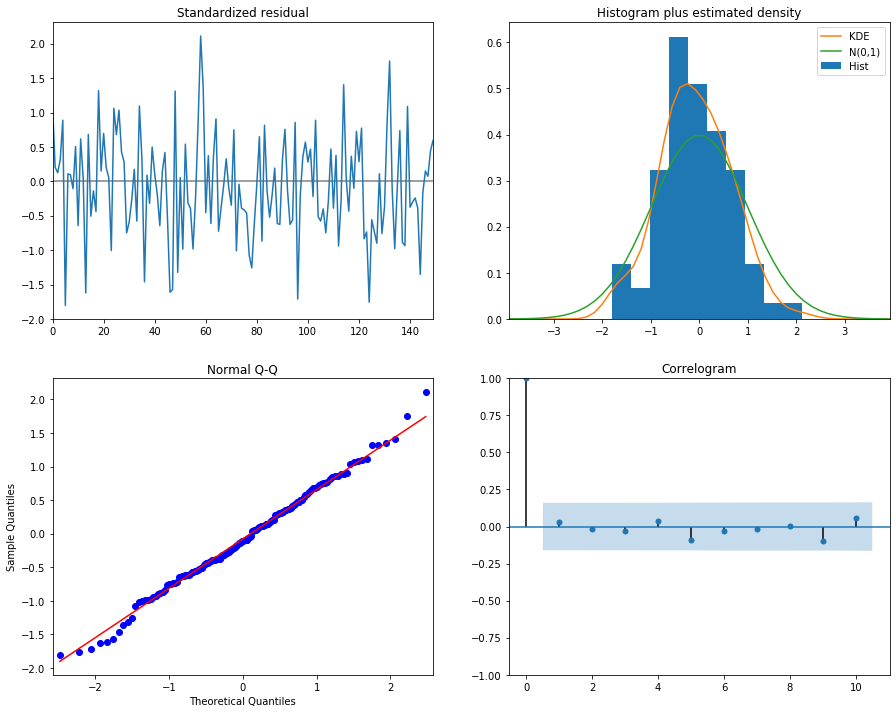

In [32]:
# result = best_model.fit()
result.plot_diagnostics(figsize=(15, 12))
plt.show()

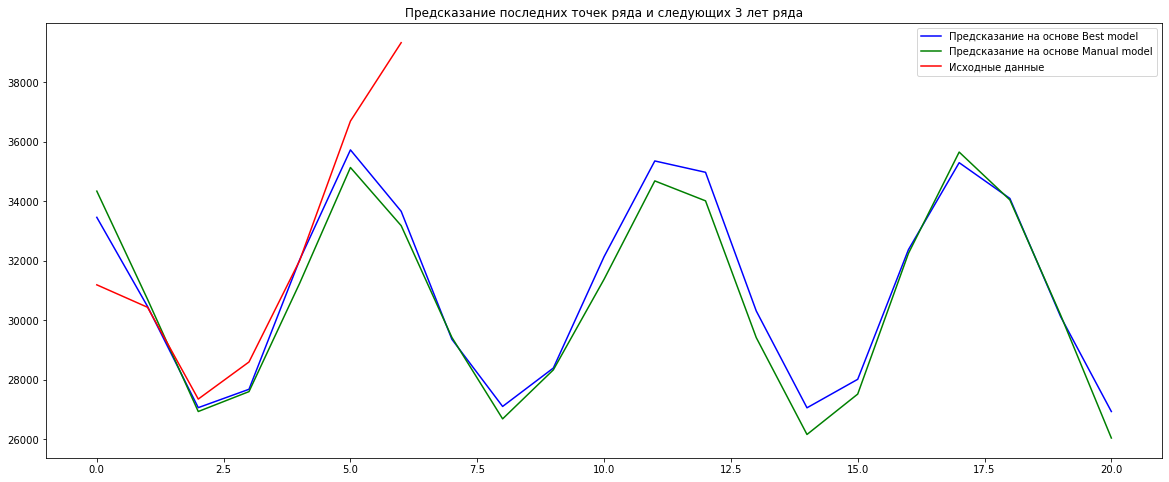

In [54]:
plt.figure(figsize=(20, 8))
pred_dynamic_manual = result_manual.forecast(21)
pred_dynamic_optimal = result.forecast(21)
plt.plot(pred_dynamic_optimal,'b', label='Предсказание на основе Best model')
plt.plot(pred_dynamic_manual,'g', label='Предсказание на основе Manual model')
plt.plot(df_month.values[-7:], 'r', label='Исходные данные')
plt.title('Предсказание последних точек ряда и следующих 3 лет ряда')
plt.legend()
plt.show()

### Задача №3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

#### Вывод: <u>Наиболее вероятно, что предсказание на месячных данных более точно по сравнению с ресемплингом по неделям.</u> Предсказание тем хуже, чем дальше от последней известной точки ряда. Модель  на месячных данных лучше отражает сезонный характер данных, нежели недельный ресемплинг, т.к. период сезонности, как мы предположили и далее подтвердили - 6 месяцев.

<hr>

### Задача №4. Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг).

In [60]:
df = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates=[0])
df.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [61]:
df.tail()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2019-08-27,59.59,2019,8,27,3,239,35,1,0,0,0
2019-08-28,59.84,2019,8,28,3,240,35,2,0,0,0
2019-08-29,60.37,2019,8,29,3,241,35,3,0,0,0
2019-08-30,59.19,2019,8,30,3,242,35,4,0,0,0
2019-09-01,58.84,2019,9,1,3,244,35,6,0,1,0


In [62]:
df.describe()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
count,2667.000000,2667.000000,2667.00000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000
mean,81.533547,2014.661042,6.51706,15.715786,2.505062,182.901762,26.486689,2.537308,0.027747,0.026997,0.029621
std,26.349469,2.663525,3.43026,8.780275,1.112684,104.741067,14.935147,1.894937,0.164277,0.162104,0.169572
min,27.850000,2010.000000,1.00000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,56.840000,2012.000000,4.00000,8.000000,2.000000,92.000000,14.000000,1.000000,0.000000,0.000000,0.000000
50%,77.710000,2015.000000,7.00000,16.000000,3.000000,183.000000,27.000000,2.000000,0.000000,0.000000,0.000000
75%,108.190000,2017.000000,9.00000,23.000000,3.000000,273.000000,39.000000,4.000000,0.000000,0.000000,0.000000
max,126.900000,2019.000000,12.00000,31.000000,4.000000,366.000000,53.000000,6.000000,1.000000,1.000000,1.000000


In [63]:
df_month = df.resample('M').mean()
df_month = df_month['Значение']

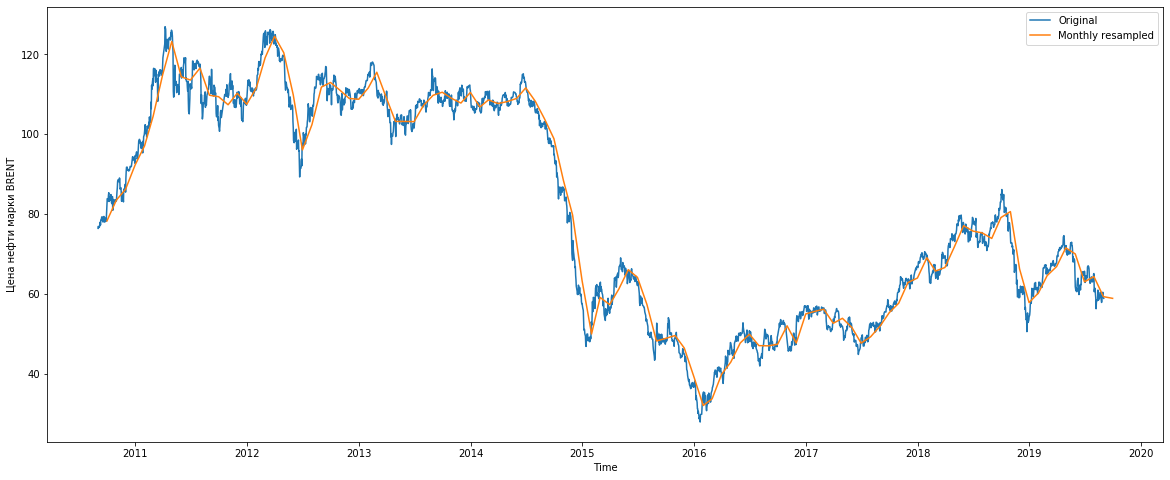

In [66]:
plt.figure(figsize=(20, 8))
plt.plot(df['Значение'], label='Original')
plt.plot(df_month, label='Monthly resampled')
plt.ylabel('Цена нефти марки BRENT')
plt.xlabel('Time')
plt.legend()
plt.show()

In [67]:
df_stats = df_month.describe()
df_stats

count    109.000000
mean      80.571077
std       26.667645
min       31.984737
25%       57.264074
50%       75.704800
75%      108.559167
max      124.502308
Name: Значение, dtype: float64

In [68]:
v = df_stats['std'] / df_stats['mean']
print(f'Коэффициент вариации = {v}')

Коэффициент вариации = 0.3309828570021416


In [69]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = jb(df_month)
a = np.vstack([jb_test])
_jb = SimpleTable(a, row)
print(_jb)

        JB                p-value                skew             kurtosis     
-------------------------------------------------------------------------------
10.560743070024175 0.0050905391277947035 0.02359750358112619 1.4758366696031897
-------------------------------------------------------------------------------


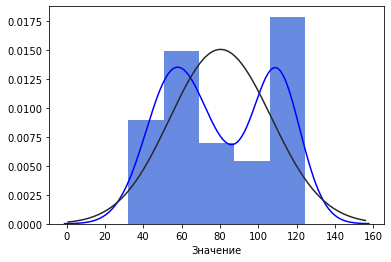

In [74]:
plt_sns = sns.distplot(df_month, color='blue')
plt_sns = sns.distplot(df_month, kde=False, fit=stats.gamma)

In [75]:
adf_test = sm.tsa.adfuller(df_month)
print(f'adf: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print(f'Critical values: {adf_test[4]}')
print('Есть единичные корни, ряд не стационарен') if adf_test[0] > adf_test[4]['5%'] \
                                                  else print('Единичных корней нет, ряд стационарен')

adf: -1.161552505213965
p-value: 0.6899124464943507
Critical values: {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}
Есть единичные корни, ряд не стационарен


### Ряд my_BRENT2019.csv не стационарен.

In [76]:
df_month_1diff = df_month.diff(periods=1).dropna()

In [77]:
adf_test = sm.tsa.adfuller(df_month_1diff)
print(f'adf: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print(f'Critical values: {adf_test[4]}')
print('Есть единичные корни, ряд не стационарен') if adf_test[0] > adf_test[4]['5%'] \
                                                  else print('Единичных корней нет, ряд стационарен')

adf: -6.750960556928634
p-value: 2.951959838243508e-09
Critical values: {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}
Единичных корней нет, ряд стационарен


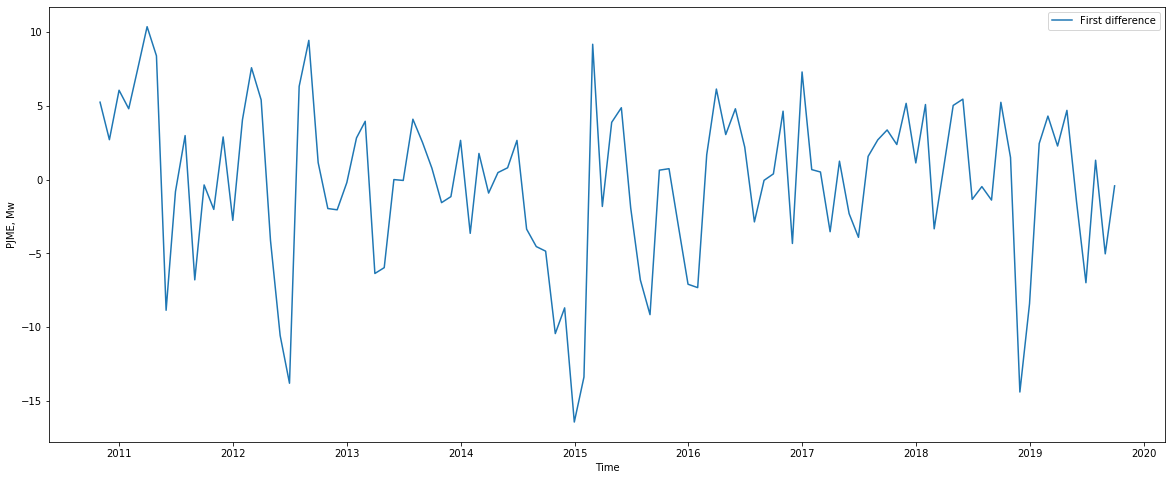

In [78]:
plt.figure(figsize=(20, 8))
plt.plot(df_month_1diff, label='First difference')
plt.ylabel('PJME, Mw')
plt.xlabel('Time')
plt.legend()
plt.show()

In [79]:
d_ARIMA = 1

In [80]:
df_month.shape

(109,)

[1.         0.97692167 0.9402959  0.90545843]
0.9054584293130633 0.976921667685448
[ 1.          0.98596724 -0.51168242  0.38443271]
-0.5116824230795757 0.9859672386825356


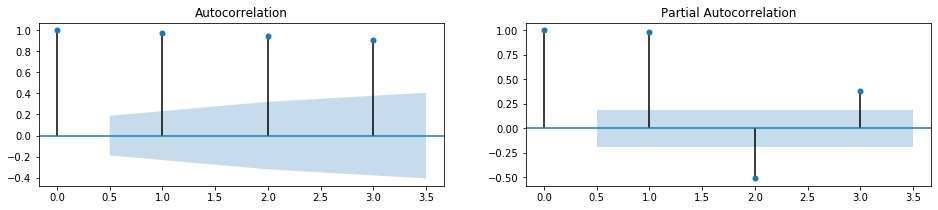

[1.         0.97692167 0.9402959  0.90545843 0.87428821 0.84774807
 0.82149105]
0.8214910494022346 0.976921667685448
[ 1.          0.98596724 -0.51168242  0.38443271 -0.19255298  0.28779802
 -0.40706985]
-0.5116824230795757 0.9859672386825356


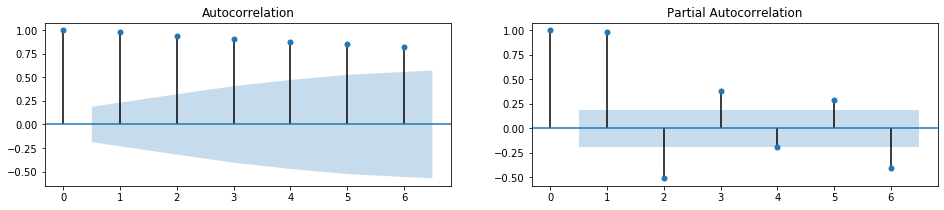

[1.         0.97692167 0.9402959  0.90545843 0.87428821 0.84774807
 0.82149105 0.79278636 0.7642521  0.7365171 ]
0.7365171034429214 0.976921667685448
[ 1.          0.98596724 -0.51168242  0.38443271 -0.19255298  0.28779802
 -0.40706985  0.36449642 -0.39589663  0.51906683]
-0.5116824230795757 0.9859672386825356


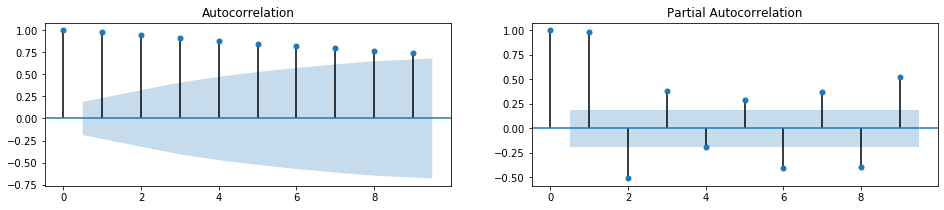

[1.         0.97692167 0.9402959  0.90545843 0.87428821 0.84774807
 0.82149105 0.79278636 0.7642521  0.7365171  0.7059699  0.67379104
 0.63962246]
0.6396224616651758 0.976921667685448
[ 1.          0.98596724 -0.51168242  0.38443271 -0.19255298  0.28779802
 -0.40706985  0.36449642 -0.39589663  0.51906683 -1.59206402 -2.52629865
  0.68094577]
-2.526298652191135 0.9859672386825356


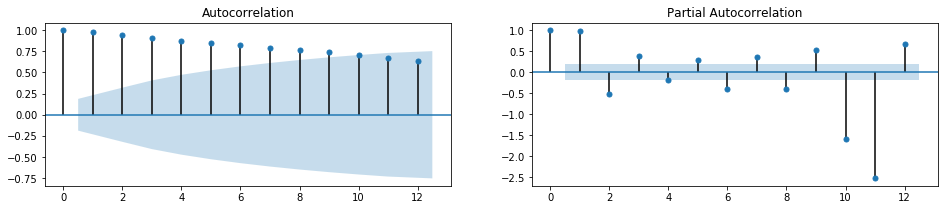

[1.         0.97692167 0.9402959  0.90545843 0.87428821 0.84774807
 0.82149105 0.79278636 0.7642521  0.7365171  0.7059699  0.67379104
 0.63962246 0.59889187 0.55521299 0.51892309 0.48681492 0.45671324
 0.42503478 0.39174368 0.35620875 0.32021145 0.28130465 0.24078617
 0.20368476]
0.2036847609622679 0.976921667685448
[ 1.          0.98596724 -0.51168242  0.38443271 -0.19255298  0.28779802
 -0.40706985  0.36449642 -0.39589663  0.51906683 -1.59206402 -2.52629865
  0.68094577 -0.67775848  0.40863662  0.09627224 -0.244683    0.01106018
  0.01665248  0.06988123 -0.31199454 -0.23549085  0.55043006 -1.15777087
 -5.40762128]
-5.407621276317665 0.9859672386825356


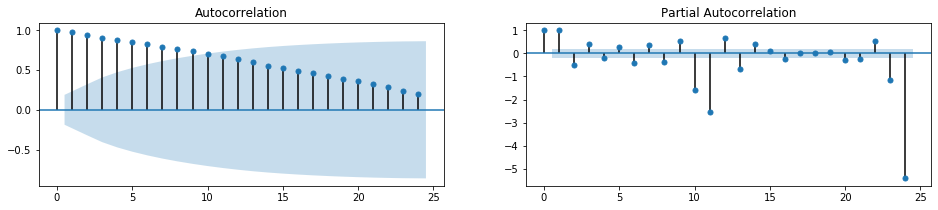

In [87]:
LAGS = [3, 6, 9, 12, 24]
acf = {}
pacf = {}
for lag in LAGS:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))
    # print(f'Count lags - {lag}')
    sm.graphics.tsa.plot_acf(df_month.values, lags=lag, ax=ax1)
    acf[lag] = sm.tsa.stattools.acf(df_month.values, nlags=lag)
    # print(f'{acf[lag]}')
    print(min(acf[lag]), max(acf[lag][1:]))
    sm.graphics.tsa.plot_pacf(df_month.values, lags=lag, ax=ax2)
    pacf[lag] = sm.tsa.stattools.pacf(df_month.values, nlags=lag)
    # print(f'{pacf[lag]}')
    print(min(pacf[lag]), max(pacf[lag][1:]))
    plt.show()

In [88]:
# исходя иp графиков ACF и PACF можем пердположить параметры p и q модели ARIMA
p_ARIMA = 1
q_ARIMA = 1

In [89]:
pdq = [p_ARIMA, d_ARIMA, q_ARIMA]
print(f'Параметры pdq модели ARIMA = {pdq}')

Параметры pdq модели ARIMA = [1, 1, 1]


In [92]:
model_arima = ARIMA(df_month.values[:-9], order=pdq)
result_arima = model_arima.fit()
print(f'ARIMA {pdq} - AIC:{result_arima.aic}')

ARIMA [1, 1, 1] - AIC:608.9958848181061


In [95]:
print(result_arima.summary().tables[0], result_arima.summary().tables[1])

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -300.498
Method:                       css-mle   S.D. of innovations              5.031
Date:                Thu, 21 May 2020   AIC                            608.996
Time:                        11:39:54   BIC                            619.376
Sample:                             1   HQIC                           613.196
                                                                              
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2037      0.745     -0.274      0.7

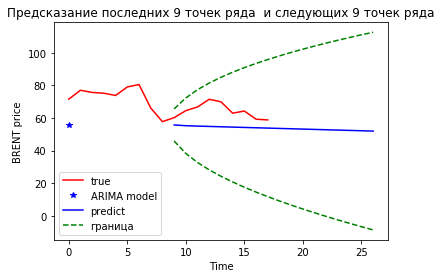

Wall time: 218 ms


In [104]:
%%time
predict = result_arima.predict(len(df_month.values[:-9]), len(df_month.values[:-9]), typ='levels')
forecast = result_arima.forecast(18)
plt.plot(df_month.values[-18:], 'r', label ='true')
plt.plot(predict, '*b', label ='ARIMA model')

plt.plot(np.arange(18) + 9, forecast[0], 'g', label ='predict', color='blue')
plt.plot(np.arange(18) + 9, forecast[2][:,1], '--g', label = 'граница')
plt.plot(np.arange(18) + 9, forecast[2][:,0], '--g')
plt.xlabel('Time')
plt.ylabel('BRENT price')
plt.title('Предсказание последних 9 точек ряда  и следующих 9 точек ряда')
plt.legend()
plt.show()

### Задача 5. Оцените результат моделирования

#### Вывод: В ряже цен нефти марки BRENT отсутствует сезонность, но присутствует тренд (о чем говорил достаточно медленное схождение/стремление к 0 графика автокорреляции). Результаты моделирования удовлетворительные, на более длинных отрезках предсказания будет сильная ошибка и данным предсказания нельзя будет верить. Наилучшие результары предсказания будут на шаг вперед.